# Project 1 for Introduction Of Data Science Subject (2023.1)

## Name: Gabriel Vicente Rodrigues
## NUSP: 11795377
## Email: gabriel_vr@usp.br

The objective of this project is to practice methods of quantizing images using 2 different approaches: the first one is using an uniform approach; the second one is a clustering approach using the K-Means algorithm.

The project is divide into 4 questions, each one inteded to practice for a specific topic of the subject.

## Initial Configurations

In [87]:
# imports and installations
#!pip install bitstring

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from bitstring import BitArray, Bits, BitStream
import pickle
from sklearn.cluster import KMeans

from sklearn.datasets import load_sample_image


In [88]:
# code supplied by professor

class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))
        
        self._mat2bytes(mat_rgb_ids)
        
    def _mat2bytes(self, mat):
        self.pixel_bytes_ = BitStream()
        
        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(Bits(uint=int(rgb_id), length=self.num_bits_uint_))
        
    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_
        
        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)
        
        # unpack RGB
        im_rgb = np.zeros((self.im_shape_[0], self.im_shape_[1], 3), dtype='uint8')
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]
                
        return im_rgb

In [89]:
def uniform_quant(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel

In [90]:
def get_bin_size_kb(obj):
    return len(pickle.dumps(obj)) / 1e3

## Question 1

### a) Modify uniform quantization function to use the middle of the interval

In [91]:
def uniform_quant_middle_interval(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals)) 

    # for each value, sum half of the bin size in the last component
    for i in range(len(pixel_vals)):
        pixel_vals[i] = (pixel_vals[i][0], pixel_vals[i][1], pixel_vals[i][2] + bin_size//2)    
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)

    # for each pixel, sum half of the bin size in the last component
    im_qt_rgb[:, :, 2] += bin_size // 2

    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel

### b) Load china.jpg image from scikit-learn and show the original one and the 2 versions of the uniform quantized

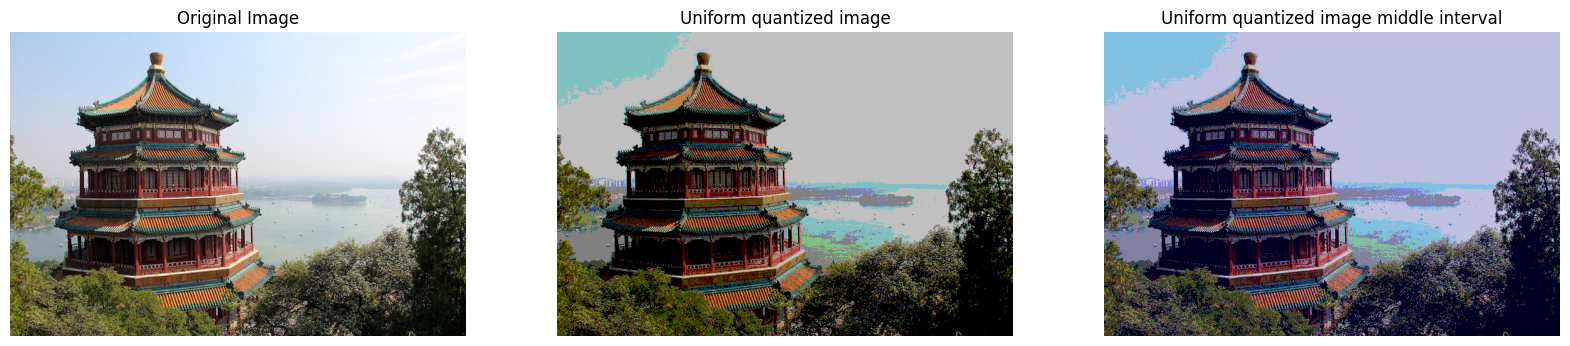

In [92]:
image = load_sample_image('china.jpg')
response1 = uniform_quant(image, 64)
response2 = uniform_quant_middle_interval(image, 64)

objQuantizedUniform = MyImgFormat(response1[0], response1[1])
objQuantizedUniformMiddle = MyImgFormat(response2[0], response2[1])

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.title("Original Image")
plt.axis('off')
plt.imshow(image)
plt.subplot(132)
plt.title("Uniform quantized image")
plt.axis('off')
plt.imshow(objQuantizedUniform.unpack())
plt.subplot(133)
plt.title("Uniform quantized image middle interval")
plt.axis('off')
plt.imshow(objQuantizedUniformMiddle.unpack())

### c) Compare the size of the three images using the function supplied

<BarContainer object of 3 artists>

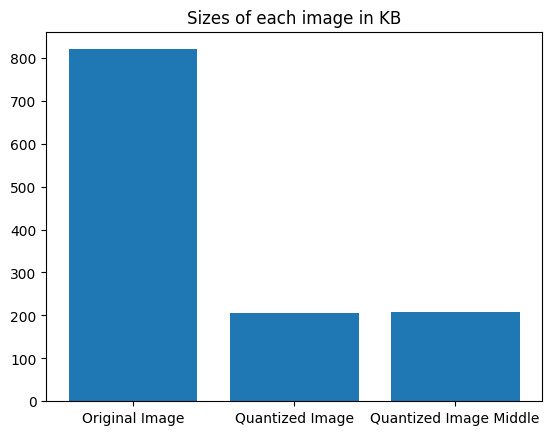

In [93]:
sizeOriginalImage = get_bin_size_kb(image)
sizeQuantizedImage = get_bin_size_kb(objQuantizedUniform)
sizeQuantizedImageMiddle = get_bin_size_kb(objQuantizedUniformMiddle)

plt.title("Sizes of each image in KB")
plt.bar(x=[0, 1, 2], height=[sizeOriginalImage, sizeQuantizedImage, sizeQuantizedImageMiddle], tick_label = ["Original Image", "Quantized Image", "Quantized Image Middle"])

It is possible to observe that the quantized images are 4 times smaller than the original one. 

This happens because our representation of the quantizations stores a 2D matrix of ids for colors and a dictionary mapping these ids to actual RGB colors

## Question 2

### a) Create a function to quantize the image using K Means

In [94]:
def quantizationKMeans(img: np.ndarray, nColors: int) -> tuple:
    kmeans = KMeans(
        n_clusters=nColors,
        max_iter=10,
        random_state=42
    )

    X = img.reshape((-1, 3))

    kmeans.fit(X)

    clusters = kmeans.predict(X)

    imgIds = clusters.reshape((img.shape[0], img.shape[1]))

    clusterCenters = kmeans.cluster_centers_

    dict_id2RGB = { i: clusterCenters[i].astype(np.uint8) for i in range(clusterCenters.shape[0])}
    return imgIds, dict_id2RGB


### b) Run the function to quantize the original image using 64 colors and compare the result with the images from question 1

In [95]:
response = quantizationKMeans(image, 64)
objQuantizedKMeans = MyImgFormat(response[0], response[1])

/home/gabriel_vr/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


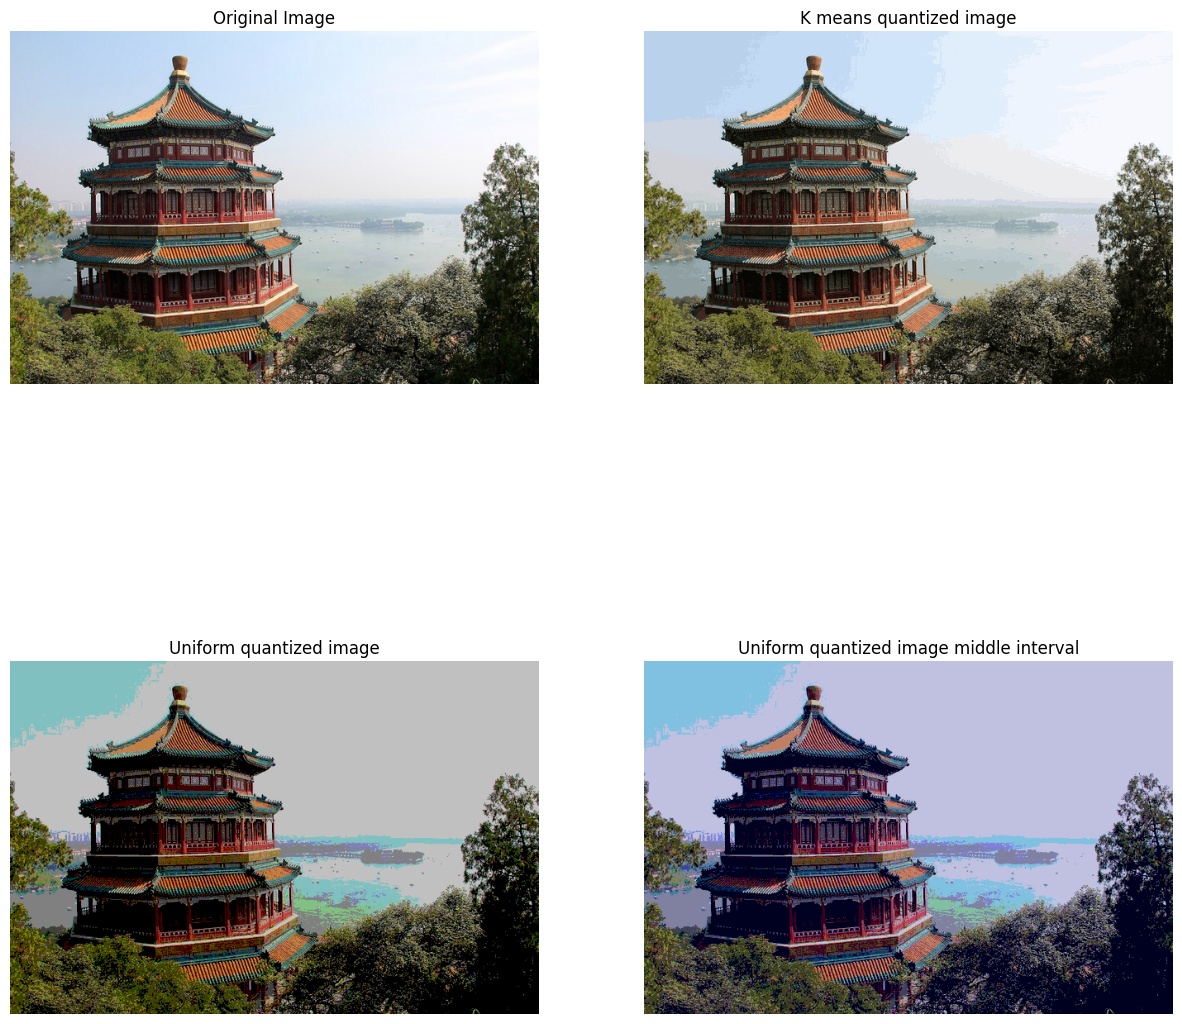

In [96]:

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0][0].set_title("Original Image")
axs[0][0].axis('off')
axs[0][0].imshow(image)

axs[0][1].set_title("K means quantized image")
axs[0][1].axis('off')
axs[0][1].imshow(objQuantizedKMeans.unpack())

axs[1][0].set_title("Uniform quantized image")
axs[1][0].axis('off')
axs[1][0].imshow(objQuantizedUniform.unpack())

axs[1][1].set_title("Uniform quantized image middle interval")
axs[1][1].axis('off')
axs[1][1].imshow(objQuantizedUniformMiddle.unpack())

It is possible to observe that the image quantized using kmeans is much smoother than the ones quantized with the uniform method.

This happens because the KMeans method selects the colors (cluster centers) based on the distribution of the data. For example, if the image has much more colors in a small RGB interval, this interval will have more representation in the final result. It will also exclude some intervals of the original domain in the final result because these intervals are not present in the image.

## Question 3

### a) Implement the calculation of the inertia related to KMeans

In [97]:
def quantizationKMeans2(img: np.ndarray, nColors: int) -> tuple:
    kmeans = KMeans(
        n_clusters=nColors,
        max_iter=10,
        random_state=42
    )

    X = img.reshape((-1, 3))

    kmeans.fit(X)

    clusters = kmeans.predict(X)

    imgIds = clusters.reshape((img.shape[0], img.shape[1]))

    clusterCenters = kmeans.cluster_centers_

    dict_id2RGB = { i: clusterCenters[i].astype(np.uint8) for i in range(clusterCenters.shape[0])}
    return imgIds, dict_id2RGB, kmeans.inertia_


### b) Implement a function to calculate the MSE between 2 images

In [98]:
def mse(img1: np.ndarray, img2: np.ndarray) -> float:
    difference = img1.astype(np.float64) - img2.astype(np.float64)
    square = np.power(difference, 2)
    X, Y, Z = img1.shape
    return np.sum(square)/(X*Y*Z)

## Question 4 (use china.jpg and flower.jpg)

In [99]:
china = image
flower = load_sample_image('flower.jpg')

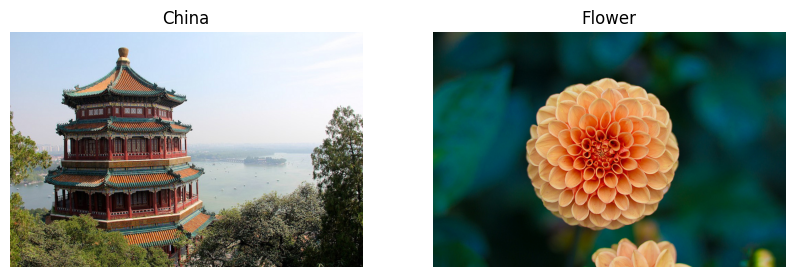

In [100]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.axis('off')
plt.title("China")
plt.imshow(china)
plt.subplot(122)
plt.axis('off')
plt.title("Flower")
plt.imshow(flower)

### a) Quantize the images using 8, 27, 64, 125, 216 colors using uniform and KMeans Method

In [101]:
nColorsArray = [8, 27, 64, 125, 216]
kmeansResultsChina = []
kmeansResultsFlower = []
uniformResultsChina = []
uniformResultsFlower = []

In [102]:
for nColors in nColorsArray:
    kmeansResultsChina.append(quantizationKMeans2(china, nColors))
    kmeansResultsFlower.append(quantizationKMeans2(flower, nColors))
    uniformResultsChina.append(uniform_quant_middle_interval(china, nColors))
    uniformResultsFlower.append(uniform_quant_middle_interval(flower, nColors))

/home/gabriel_vr/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabriel_vr/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabriel_vr/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabriel_vr/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabriel_vr/.lo

In [103]:
myImageFormatKmeansChina = []
myImageFormatKmeansFlower = []
myImageFormatUniformChina = []
myImageFormatUniformFlower = []


for i in range(len(nColorsArray)):
    myImageFormatKmeansChina.append(MyImgFormat(kmeansResultsChina[i][0], kmeansResultsChina[i][1]))
    myImageFormatKmeansFlower.append(MyImgFormat(kmeansResultsFlower[i][0], kmeansResultsFlower[i][1]))
    myImageFormatUniformChina.append(MyImgFormat(uniformResultsChina[i][0], uniformResultsChina[i][1]))
    myImageFormatUniformFlower.append(MyImgFormat(uniformResultsFlower[i][0], uniformResultsFlower[i][1]))

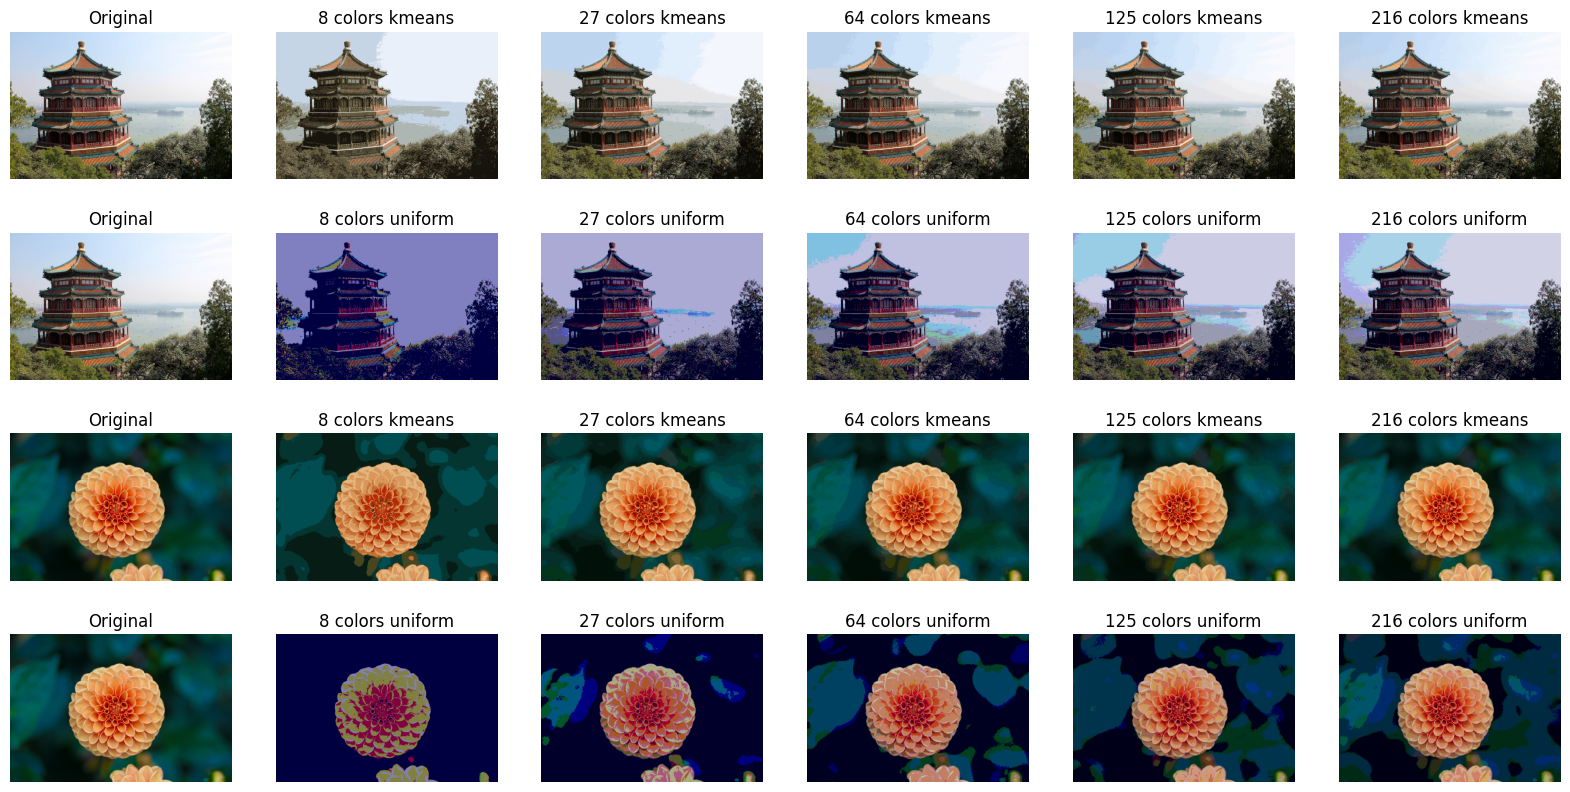

In [110]:


fig, axs = plt.subplots(4, 6, figsize=(20, 10))

def pltImagesAxLine(images: np.ndarray, axsLine: np.ndarray, labelImages: list):
    for img, ax, label in zip(images, axsLine, labelImages):
        ax.axis('off')
        ax.set_title(label)
        ax.imshow(img)

plotImagesKmeansChina = [china]
for image in myImageFormatKmeansChina:
    plotImagesKmeansChina.append(image.unpack())
pltImagesAxLine(plotImagesKmeansChina, axs[0], ["Original", "8 colors kmeans", "27 colors kmeans", "64 colors kmeans", "125 colors kmeans", "216 colors kmeans"])

plotImagesUniformChina = [china]
for image in myImageFormatUniformChina:
    plotImagesUniformChina.append(image.unpack())
pltImagesAxLine(plotImagesUniformChina, axs[1], ["Original", "8 colors uniform", "27 colors uniform", "64 colors uniform", "125 colors uniform", "216 colors uniform"])

plotImagesKmeansFlower= [flower]
for image in myImageFormatKmeansFlower:
    plotImagesKmeansFlower.append(image.unpack())
pltImagesAxLine(plotImagesKmeansFlower, axs[2], ["Original", "8 colors kmeans", "27 colors kmeans", "64 colors kmeans", "125 colors kmeans", "216 colors kmeans"])

plotImagesUniformFlower = [flower]
for image in myImageFormatUniformFlower:
    plotImagesUniformFlower.append(image.unpack())
pltImagesAxLine(plotImagesUniformFlower, axs[3], ["Original", "8 colors uniform", "27 colors uniform", "64 colors uniform", "125 colors uniform", "216 colors uniform"])

### b) Plot the inertia values obtained from KMeans quantization

Text(0, 0.5, 'Inertia obtained from KMeans quantization')

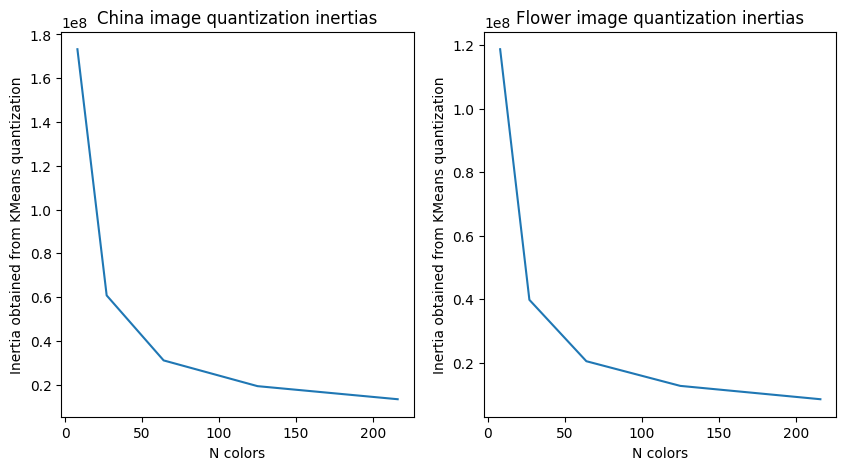

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

inertiaChina = [obj[2] for obj in kmeansResultsChina]
inertiaFlower = [obj[2] for obj in kmeansResultsFlower]

axs[0].set_title("China image quantization inertias")
axs[0].plot(nColorsArray, inertiaChina)
axs[0].set_xlabel("N colors")
axs[0].set_ylabel("Inertia obtained from KMeans quantization")

axs[1].set_title("Flower image quantization inertias")
axs[1].plot(nColorsArray, inertiaFlower)
axs[1].set_xlabel("N colors")
axs[1].set_ylabel("Inertia obtained from KMeans quantization")
    

For both images, the optimal number of clusters is 64.

[Here](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f) is an article that explains how to use the inertia to find the optimal value for the number of clusters

### c) Compute and plot the mse for the quantizations and talk about the result

In [106]:
mseKmeansChina = []
mseKmeansFlower = []
mseUniformChina = []
mseUniformFlower = []

for i in range(len(nColorsArray)):

    mseKmeansChina.append(mse(china, myImageFormatKmeansChina[i].unpack()))
    mseKmeansFlower.append(mse(flower, myImageFormatKmeansFlower[i].unpack()))
    mseUniformChina.append(mse(china, myImageFormatUniformChina[i].unpack()))
    mseUniformFlower.append(mse(flower, myImageFormatUniformFlower[i].unpack()))


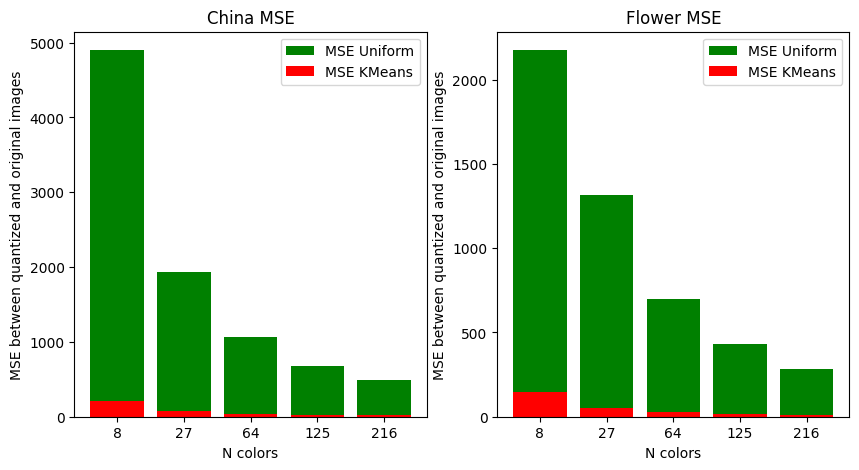

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title("China MSE")
axs[0].bar(range(len(nColorsArray)), mseUniformChina, color='green', label='MSE Uniform', tick_label=nColorsArray)
axs[0].bar(range(len(nColorsArray)), mseKmeansChina, color='red', label='MSE KMeans', tick_label=nColorsArray)
axs[0].set_xlabel("N colors")
axs[0].set_ylabel("MSE between quantized and original images")
axs[0].legend()

axs[1].set_title("Flower MSE")
axs[1].bar(range(len(nColorsArray)), mseUniformFlower, color='green', label='MSE Uniform', tick_label=nColorsArray)
axs[1].bar(range(len(nColorsArray)), mseKmeansFlower, color='red', label='MSE KMeans', tick_label=nColorsArray)
axs[1].set_xlabel("N colors")
axs[1].set_ylabel("MSE between quantized and original images")
axs[1].legend()


As we can see in both graphics, the MSE decreases as we increase the number of colors in our image. 

We can also see that the MSE for the images quantized using the KMeans method is much lower than the ones quantized using the uniform method. We can easily see these numbers in a practical way comparing the actual images, as seen in the section a) of this question.

### d) Compute and plot the size of the quantized images and compare the results with the original image

In [52]:
chinaImageSize = get_bin_size_kb(china)
flowerImageSize = get_bin_size_kb(flower)

kmeansChinaSizes = [chinaImageSize]
kmeansFlowerSizes = [flowerImageSize]
uniformChinaSizes = [chinaImageSize]
uniformFlowerSizes = [flowerImageSize]
print(kmeansChinaSizes)

for i in range(len(nColorsArray)):
    kmeansChinaSizes.append(get_bin_size_kb(myImageFormatKmeansChina[i]))
    kmeansFlowerSizes.append(get_bin_size_kb(myImageFormatKmeansFlower[i]))
    uniformChinaSizes.append(get_bin_size_kb(myImageFormatUniformChina[i]))
    uniformFlowerSizes.append(get_bin_size_kb(myImageFormatUniformFlower[i]))

[820.005]


<BarContainer object of 6 artists>

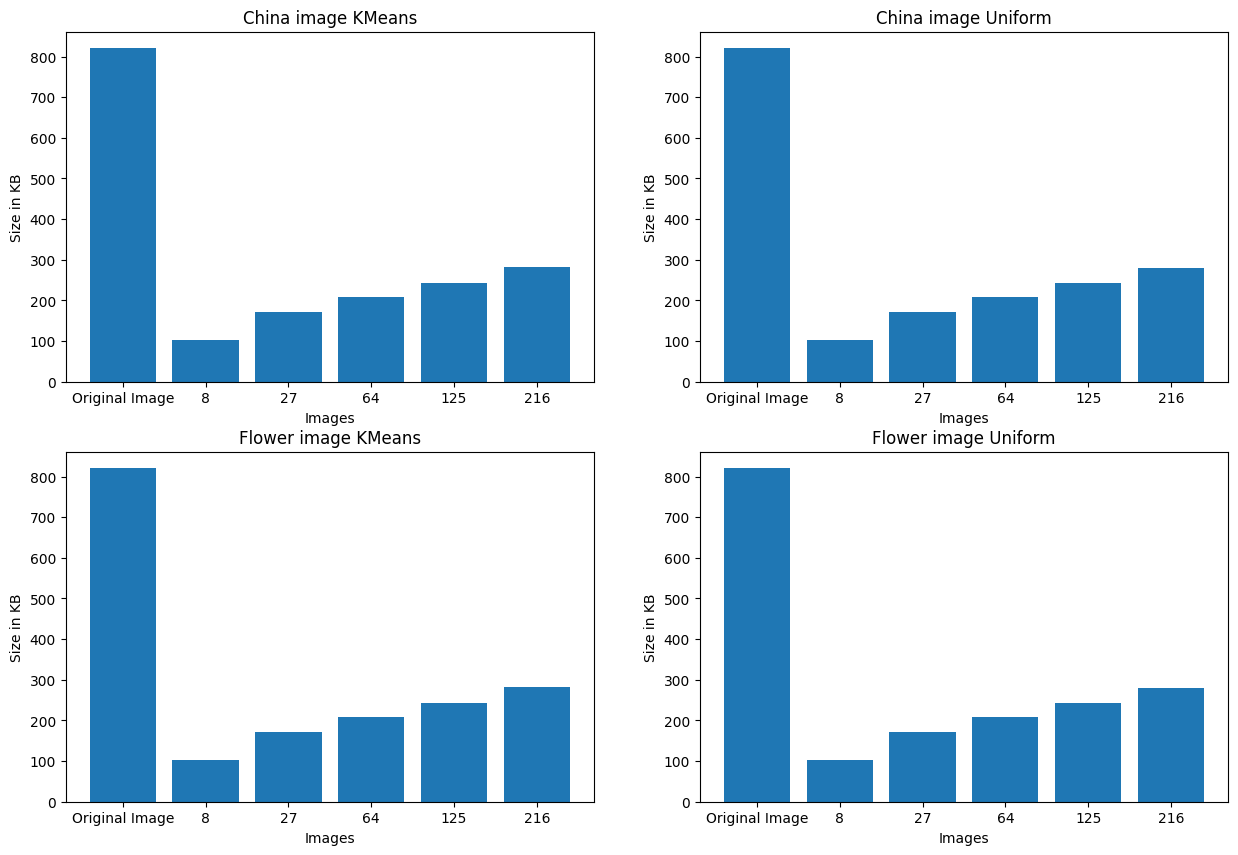

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

tick_label_nColors = np.array(nColorsArray).astype(str)

tick_label=np.concatenate((np.array(["Original Image"]).astype(str), tick_label_nColors), axis=0)


axs[0][0].set_title("China image KMeans")
axs[0][0].set_xlabel("Images")
axs[0][0].set_ylabel("Size in KB")
axs[0][0].bar(range(len(kmeansChinaSizes)), kmeansChinaSizes, tick_label=tick_label)

axs[0][1].set_title("China image Uniform")
axs[0][1].set_xlabel("Images")
axs[0][1].set_ylabel("Size in KB")
axs[0][1].bar(range(len(uniformChinaSizes)), uniformChinaSizes, tick_label=tick_label)

axs[1][0].set_title("Flower image KMeans")
axs[1][0].set_xlabel("Images")
axs[1][0].set_ylabel("Size in KB")
axs[1][0].bar(range(len(kmeansFlowerSizes)), kmeansFlowerSizes, tick_label=tick_label)

axs[1][1].set_title("Flower image Uniform")
axs[1][1].set_xlabel("Images")
axs[1][1].set_ylabel("Size in KB")
axs[1][1].bar(range(len(uniformFlowerSizes)), uniformFlowerSizes, tick_label=tick_label)

The graphics show that the size of the quantized images stored are much lower than the original image, specially if we store less number of colors. For the purposes of an application, we have to ponder what is more important: quality or space. 

## Conclusion

The analises made in this project show the process of quantizing an image usign different methods and how to tell wich one is better.

#### The Methods

For quantizing an image we need to store it in a different data structure, saving its colors in a dictionary and a map for the colors as the image.
The size of the map is always the same as our quantization is not intended to decrease the resolution, but the range of colors.

A method of quantization receives a number of colors and has to select values from the domain. After that, the method must modify the image to be a map which each pixel points to a color. The KMeans method is much better than the uniform because it uses a strategy of learning the distribution of the data to select the best colors, that are those that appears more in the image.

#### The analises

A superficial analisys of the methods is to compare the actual images created, as done in the question 4a. It was seen that the KMeans perfomed much better than the uniform method, showing images much smoother even with the same number of colors.

A deeper analisys is done by computing the Mean Square error between the quantized image and the original one. This method showed a very large differente between the cluster method and the uniform one. 

A question raised is what is the optimal number of colors to quantize an image using the KMeans method. It can be responded using the inertia, which is a value correspondig to the distance between the test data and the clusters. As the inertia decreases, the distance decreases and the result is better. First we need to compute the inertia for a series of KMeans with different number of clusters. Then we plot the values and look for the shape of the graphic and if it looks like an arm, the optimal value is in the elbow.

Lastly, we can see the size of the image when it is stored in a memory device. The quantized images occupies much less space, which leads to a question: what our application needs: saving space or better graphics?